# CTA - Homework 1
## Tasks
- (1) Pick a topic that you are interested in and exists as a Wikipedia category or subcategory and extract the title, summary (and anything els e you
like, e.g., German equivalents). Chose a category that has at least 20-30 pages (better >50).  

- (2) Organize (and clean) the data into a dataframe. Add text features (length of title/description, TTR, POSs), and conduct an exploratory data &
text analysis, e.g., missing data points, length of lead section, inspect content of text.  

- (3) Summarize your learnings including shortcomings of the used NLP tools and text.  

- (4) Submit your Colab notebook by 31st December 2021. If you submit earlier, the instructors will be thankful. If you submit later, you will get 
zero points (%) for this exercise.  

Add your shared Colab notebook link here: [https://docs.google.com/spreadsheets/d/1wi2MfvjOh5_SOYLE46RnE-lUuN1GZPwyilbaDGitxLQ/edit?usp=sharing]()

If you want that only the instructors see your Colab notebook, you can add the following email to the shared list and select Restricted 
share: hslu.clt@gmail.com 

## Introduction
The topic I have chosen is NLP. But why NLP? I wanted to find out what different categories and terms around this topic can be found on Wikipedia. 

I will show or deepen the following points with this report:

- How to use the Wikipedia API
- Manipulation of text data into a pandas dataframe
- Feature engineering using Pandas Dataframe, Spacy Pipeline
- Graphical analysis of selected features
- Wordcloud of all articles (194)

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install these if not already installed
!pip install WordCloud
!pip install --upgrade spacy
!pip install wikipedia-api
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 777.4 MB 4.6 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import os,json
import wikipediaapi

import numpy as np
import pandas as pd

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# Load spacy pipeline for English (large)
nlp = spacy.load("en_core_web_lg")

from textblob import TextBlob

import pandas_profiling as prof

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from wordcloud import WordCloud 

# Set preferences
pd.set_option('display.max_columns', None)
#pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

# Set preferences
sns.set(color_codes=True)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

## EDA / ETA of data
### Data Extraction

In [ ]:
# Define language and page
wiki = wikipediaapi.Wikipedia('en')
page_ds = wiki.page('Natural language processing')

In [ ]:
page_ds.title

'Natural language processing'

In [ ]:
page_ds.summary

'Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language, in particular how to program computers to process and analyze large amounts of natural language data.  The goal is a computer capable of "understanding" the contents of documents, including the contextual nuances of the language within them. The technology can then accurately extract information and insights contained in the documents as well as categorize and organize the documents themselves.\nChallenges in natural language processing frequently involve speech recognition, natural language understanding, and natural language generation.'

In [ ]:
# Get members for a category together with a short description
def members_collector(category):
      mdict = {}
      categorymembers = category.categorymembers
      for c in categorymembers.values():
        if c.ns == 0: # Exclude categories within the category
          mdict[c.title] = c.summary
      return mdict

# Let's collect all sections of the category
nlp_wiki = wiki.page("Category:Natural_language_processing")
nlp_wikidict = members_collector(nlp_wiki)

# Create dataframe
nlp_wiki_df = pd.DataFrame([nlp_wikidict.keys(), nlp_wikidict.values()]).T
nlp_wiki_df.columns = ['Name', 'Description']

nlp_wiki_df.head()

,Name,Description
0,Natural language processing,"Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language, in particular how to program computers to process and analyze large amounts of natural language data. The goal is a computer capable of ""understanding"" the contents of documents, including the contextual nuances of the language within them. The technology can then accurately extract information and insights contained in the documents as well as categorize and organize the documents themselves.\nChallenges in natural language processing frequently involve speech recognition, natural language understanding, and natural language generation."
1,Outline of natural language processing,"The following outline is provided as an overview of and topical guide to natural language processing:\nNatural language processing – computer activity in which computers are entailed to analyze, understand, alter, or generate natural language. This includes the automation of any or all linguistic forms, activities, or methods of communication, such as conversation, correspondence, reading, written composition, dictation, publishing, translation, lip reading, and so on. Natural language processing is also the name of the branch of computer science, artificial intelligence, and linguistics concerned with enabling computers to engage in communication using natural language(s) in all forms, including but not limited to speech, print, writing, and signing."
2,Abdul Majid Bhurgri Institute of Language Engineering,"Abdul Majid Bhurgri Institute of Language Engineering (Sindhi: عبدالماجد ڀرڳڙي انسٽيٽيوٽ آف لئنگئيج انجنيئرنگ) is an autonomous body under the administrative control of the Culture, Tourism and Antiquities Department, Government of Sindh established for bringing Sindhi language at par with national and international languages in all computational process and Natural language processing."
3,Affix grammar over a finite lattice,"In linguistics, the affix grammars over a finite lattice (AGFL) formalism is a notation for context-free grammars with finite set-valued features, acceptable to linguists of many different schools.\nThe AGFL-project aims at the development of a technology for Natural language processing available under the GNU GPL."
4,AFNLP,AFNLP (Asian Federation of Natural Language Processing Associations) is the organization for coordinating the natural language processing related activities and events in the Asia-Pacific region.


In [ ]:
nlp_wiki_df.shape

(194, 2)

### Data Cleaning

In [ ]:
# \n is present in Description -> .str.replace() method
nlp_wiki_df['Description'] = (nlp_wiki_df['Description'].str.replace('\n', ' '))
# Missing data check
nlp_wiki_df.isna().sum()

Name           0
Description    0
dtype: int64

No missing values, we are good to go :)  

Next step, we can start to add features to this data such as:  
- num_word_token: Describing the number of words in the text.
- num_word_type: Describing the number of unique words in the text.
- num_TTR: Describing the type-token ratio of the text.
- num_Polarity: Describing the polarity of the text (values: `[-1,...,1]` -> -1 negative, +1 positive).
- num_Subjectivity: Describing the subjectivity of the text (values: `[0,...,1]` -> 0 objective, +1 subjective).

In [ ]:
# Generate a column with the number of word-token
nlp_wiki_df['num_word_token'] = nlp_wiki_df['Description'].apply(lambda x: len(x.split()))

# Generate the column with the number of unique tokens (type)
nlp_wiki_df['num_word_type'] = nlp_wiki_df['Description'].apply(lambda x: len(set(str(x).split())))

# Generate TTR
nlp_wiki_df['num_TTR'] = round(nlp_wiki_df['num_word_type'] / nlp_wiki_df['num_word_token'],4)

# Add polarity
nlp_wiki_df['num_Polarity'] = nlp_wiki_df['Description'].map(lambda text: TextBlob(str(text)).sentiment.polarity)

# Add subjectivity
nlp_wiki_df['num_Subjectivity'] = nlp_wiki_df['Description'].map(lambda text: TextBlob(str(text)).sentiment.subjectivity)

### Feature Engineering: NER with SpaCy
Let's process the description by Spacy and see what features can be extracted. First, let's create a subset of the dataframe containing only the description of the articles.

In [ ]:
df = nlp_wiki_df[['Description']]

pos = {}
for n,text in enumerate(df.Description):
    vocabulary = {}
    doc = nlp(text)
    for token in doc:
        if token.is_stop:
            if 'stopword' in vocabulary:
                vocabulary['num_stopword'] += 1
            else:
                vocabulary['num_stopword'] = 1 
        elif token.is_punct:
            if 'punct' in vocabulary:
                vocabulary['num_punct'] += 1
            else:
                vocabulary['num_punct'] = 1 
        else:           
            if token.pos_ in vocabulary:
                vocabulary[f'num_{token.pos_}'] += 1
                vocabulary[f'{token.pos_}'] += [token.text]
            else:
                vocabulary[f'num_{token.pos_}'] = 1
                vocabulary[f'{token.pos_}'] = [token.text]
    pos[f'article_{n}'] = vocabulary

df_pos = pd.DataFrame.from_dict(pos, orient='index').reset_index().drop(columns=['index'])
df_ = pd.concat([df,df_pos], axis=1).drop(columns=['Description'])

The ner-tags for spacy are as follows:  

![spacy legend](/content/drive/MyDrive/NaturalLanguageUnderstanding/homework/spacy_legend.png)

In [ ]:
nlp_wiki_df = pd.concat([nlp_wiki_df,df_], axis=1)
nlp_wiki_df.head()

,Name,Description,num_word_token,num_word_type,num_TTR,num_Polarity,num_Subjectivity,num_ADJ,ADJ,num_NOUN,NOUN,num_punct,num_PROPN,PROPN,num_stopword,num_VERB,VERB,num_SPACE,SPACE,num_ADV,ADV,num_NUM,NUM,num_X,X,num_ADP,ADP,num_SYM,SYM,num_PUNCT,PUNCT,num_AUX,AUX,num_CCONJ,CCONJ,num_DET,DET,num_INTJ,INTJ,num_PRON,PRON
0,Natural language processing,"Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language, in particular how to program computers to process and analyze large amounts of natural language data. The goal is a computer capable of ""understanding"" the contents of documents, including the contextual nuances of the language within them. The technology can then accurately extract information and insights contained in the documents as well as categorize and organize the documents themselves. Challenges in natural language processing frequently involve speech recognition, natural language understanding, and natural language generation.",98,65,0.6633,0.081746,0.432937,11.0,"[Natural, artificial, human, particular, large, natural, capable, contextual, natural, natural, natural]",34.0,"[language, processing, subfield, linguistics, computer, science, intelligence, interactions, computers, language, computers, amounts, language, data, goal, computer, contents, documents, nuances, language, technology, information, insights, documents, documents, Challenges, language, processing, speech, recognition, language, understanding, language, generation]",1,1.0,[NLP],1,11.0,"[concerned, program, process, analyze, understanding, including, extract, contained, categorize, organize, involve]",1.0,[ ],2.0,"[accurately, frequently]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Outline of natural language processing,"The following outline is provided as an overview of and topical guide to natural language processing: Natural language processing – computer activity in which computers are entailed to analyze, understand, alter, or generate natural language. This includes the automation of any or all linguistic forms, activities, or methods of communication, such as conversation, correspondence, reading, written composition, dictation, publishing, translation, lip reading, and so on. Natural language processing is also the name of the branch of computer science, artificial intelligence, and linguistics concerned with enabling computers to engage in communication using natural language(s) in all forms, including but not limited to speech, print, writing, and signing.",106,77,0.7264,0.003247,0.353896,10.0,"[following, topical, natural, Natural, natural, linguistic, Natural, artificial, concerned, natural]",40.0,"[outline, overview, guide, language, processing, language, processing, computer, activity, computers, language, automation, forms, activities, methods, communication, conversation, correspondence, reading, composition, dictation, publishing, translation, lip, reading, language, processing, branch, computer, science, intelligence, linguistics, computers, communication, language(s, forms, speech, print, writing, signing]",1,NaN,NaN,1,12.0,"[provided, entailed, analyze, understand, alter, generate, includes, written, enabling, engage, including, limited]",2.0,"[ , ]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Abdul Majid Bhurgri Institute of Language Engineering,"Abdul Majid Bhurgri Institute of Language Engineering (Sindhi: عبدالماجد ڀرڳڙي انسٽيٽيوٽ آف لئنگئيج انجنيئرنگ) is an autonomous body under the administrative control of the Culture, Tourism and Antiquities Department, Government of Sindh established for bringing Sindhi language at par with national and international languages in all computational process and Natural language processing.",52,46,0.8846,0.166667,0.366667,7.0,"[autonomous, administrative, Sindhi, national, internationa

### Graphical EDA
There are two features that would be very interesting to have a closer look at:
- Polarity (Describes the polarity of the text (values: `[-1,...,1]` -> -1 negative, +1 positive)
- Subjectivity (Describes the subjectivity of the text (values: `[0,...,1]` -> 0 objective, +1 subjective)

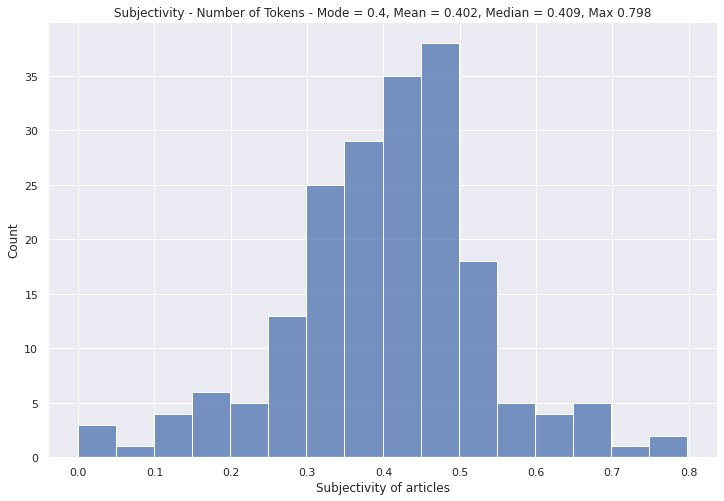

In [ ]:
# Histogram of number of tokens for subjectivity
plt.figure(figsize=(12, 8))
sns.histplot(x='num_Subjectivity', data=nlp_wiki_df)
plt.title('Subjectivity - Number of Tokens - Mode = {}, Mean = {}, Median = {}, Max {}'.format(
    nlp_wiki_df['num_Subjectivity'].mode()[0],
    round(nlp_wiki_df['num_Subjectivity'].mean(),3),
    round(nlp_wiki_df['num_Subjectivity'].median(),3),
    round(nlp_wiki_df['num_Subjectivity'].max(),3)))
plt.xlabel('Subjectivity of articles')
plt.show()

It is visible that most of the articles are neutral objective-subjective, since the values are approximately at 0.4.  

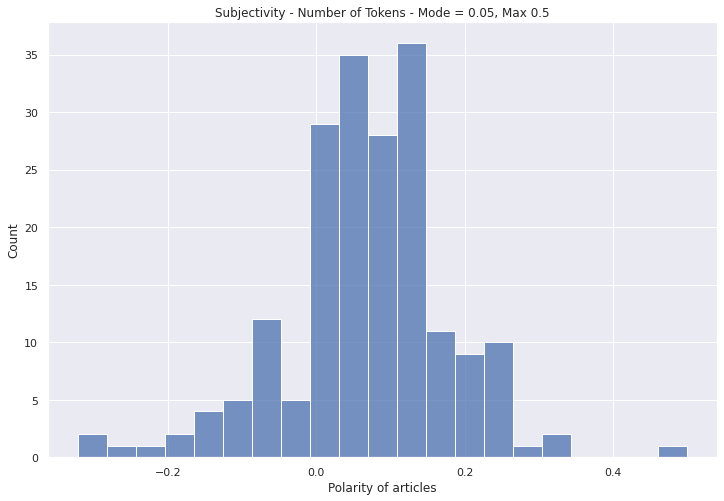

In [ ]:
# Histogram of number of tokens for subjectivity
plt.figure(figsize=(12, 8))
sns.histplot(x='num_Polarity', data=nlp_wiki_df)
plt.title('Subjectivity - Number of Tokens - Mode = {}, Max {}'.format(
    nlp_wiki_df['num_Polarity'].mode()[0],
    nlp_wiki_df['num_Polarity'].max()))
plt.xlabel('Polarity of articles')
plt.show()

Again, it is visible that most of the values are neutral (positive and negative feelings), as the values are concentrated around zero. 

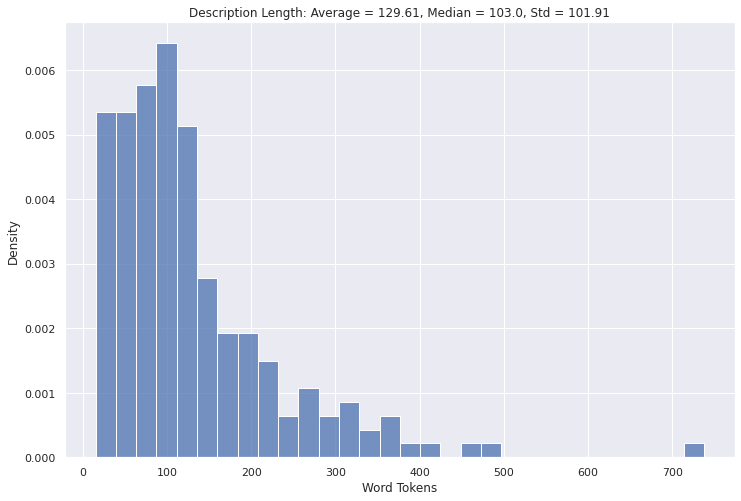

In [ ]:
# Histogram of description lengths - characters
plt.figure(figsize=(12, 8))
sns.histplot(x='num_word_token', data=nlp_wiki_df, stat='density', bins=30)
plt.title('Description Length: Average = {}, Median = {}, Std = {}'.format(
    round(nlp_wiki_df['num_word_token'].mean(), 2),
    round(nlp_wiki_df['num_word_token'].median(), 2), 
    round(nlp_wiki_df['num_word_token'].std(), 2)))
plt.xlabel('Word Tokens')
plt.show()

The histogram is significantly right skewed. The results in an average greater than the median. It can be infered that the median is a more meaningful statistic than the average. In fact, most of the description lengths lie in the bin just below 100.

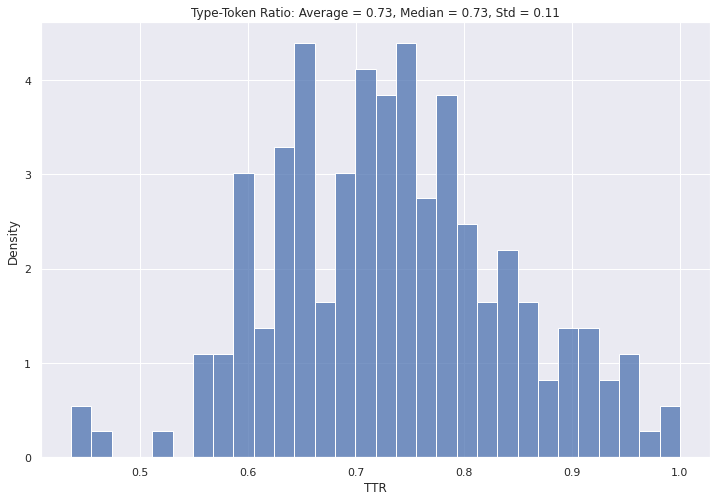

In [ ]:
# Histogram of description lengths - characters
plt.figure(figsize=(12, 8))
sns.histplot(x='num_TTR', data=nlp_wiki_df, stat='density', bins=30)
plt.title('Type-Token Ratio: Average = {}, Median = {}, Std = {}'.format(
    round(nlp_wiki_df['num_TTR'].mean(), 2),
    round(nlp_wiki_df['num_TTR'].median(), 2), 
    round(nlp_wiki_df['num_TTR'].std(), 2)))
plt.xlabel('TTR')
plt.show()

The histogram tends to show a centralized tendency around the median. The mean and median are close to each other.
The TTR indicates the degree of lexical diversity of the text.  

The graph belows supports shows the concentration of word-token and type of words in the text.

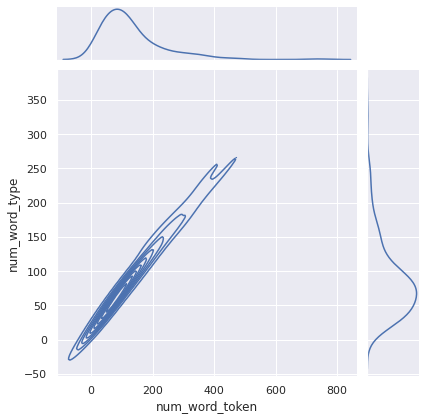

In [ ]:
# Joint probability distribution plot
sns.jointplot(x=nlp_wiki_df['num_word_token'], 
              y=nlp_wiki_df['num_word_type'],
              kind='kde')
plt.show()

### Word Cloud

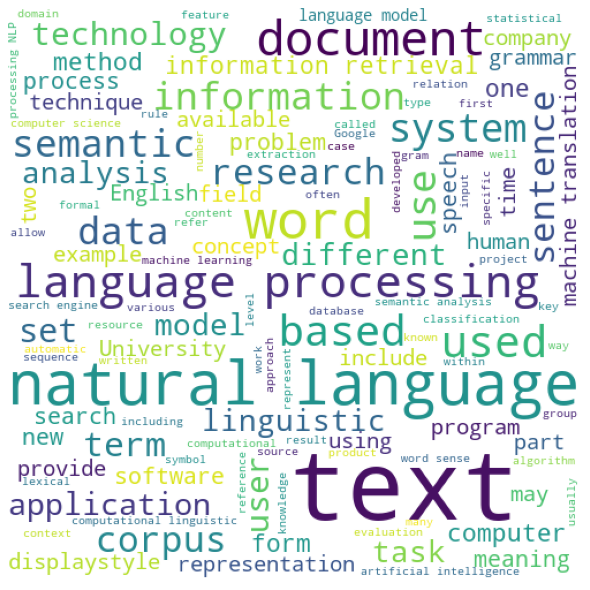

In [ ]:
all_descriptions = nlp_wiki_df['Description'].str.cat()
# Now let's generate a wordcloud for some reviews
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white',
                min_font_size = 10).generate(all_descriptions)
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

Words like "text", "natural language", "language", "language processing" are not surprising. What seems to be surprising is that out of so many articles, the cloud do not contains the word "Natural Language Processing" or "NLP" as it is not a common word, only the subset of it. 

### Conclusion

194 Wikipedia articles were extracted from the Wikipedia API.  

The goal was to use the Wikipedia API to extract the title and description of the articles and investigate the domain of the articles: NLP.  
Additional features have been added, such as word-token, word-type, TTR, polarity and subjectivity in order to apply what we have learned so far. Furthermore, Spacy was used to extract the NER-tags. 
It was also possible to extract the word-cloud of the articles and gain knowledge about common words in the articles.

The following facts have been extracted out of the data:
- The number of articles is 194.
- The most articles are neutral objective-subjective, since the values are approximately at 0.4.
- The most articles are neutral (positive and negative sentiments), as the values are concentrated around zero.
- The description lengths are concentrated around the median: 103 word-tokens, significantly right skewed.
- The TTR indicates the degree of lexical diversity of the text around a value of 0.73.
- The term "Natural Language Processing" and "NLP" are not contained in the word-cloud.

The prediction of the named-entity-using Spacy worked fine on this dataset. 

It should also be mentioned, the data cleaning was a horrible task, I scrapped first the page on investopedia with my own script in order to get the definition of all mentioned financial aspects as told to Professor Papp, but, unfortunatelly, I didn't manage to prepare the dataset in such a way that it is usable for the investigations showed above. I will for sure use those techniques and especially the semantic methods of exercise two with this dataset. 

